In [242]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import median_abs_deviation as mad
import time

Useful function for the plot

In [243]:
def display_band( X, par,epsi=0.001,col='k'):
  x1 = np.min(X[0, :])
  x2 = np.max(X[0, :])
  y1 = np.min(X[1, :])
  y2 = np.max(X[1, :])

  # extend the line for the k# of its lenght 
  k = 0.01
  dx = x2-x1
  dy = y2-y1
  l = np.sqrt(dx**2+dy**2)
  x1 = x1 - k*l
  x2 = x2 + k*l
  y1 = y1 - k*l
  y2 = y2 + k*l
  ##
  if np.abs(par[1])<2e-2 :
      #disp('vertical line')
    a = np.vstack([-(par[1]*y1 + par[2])/par[0], y1])
    b = np.vstack([-(par[1]*y2 + par[2])/par[0], y2])
  else:
    a = np.vstack([x1, -(par[0]*x1 + par[2])/par[1]])
    b = np.vstack([x2, -(par[0]*x2 + par[2])/par[1]])

  if np.abs(par[0])<1e-5:
    v = np.array([0,1]) 
  else:    
    v = np.array([1, par[1]/par[0]])# direction perpendicular to the line;

  v = v / np.sqrt(np.sum(v**2));
  # corners of the bands
  v = v[:, np.newaxis]
  a1 = a - epsi * v;
  a2 = a + epsi * v;
  b1 = b - epsi * v;
  b2 = b + epsi * v;

  px = np.array([a1[0], b1[0], b2[0], a2[0]]).squeeze()
  py = np.array([a1[1], b1[1], b2[1], a2[1]]).squeeze()
  plt.tricontourf(px,py,np.ones_like(px), colors=col,alpha=0.5)
  plt.gca().set_aspect('equal')

Function that computes the residual between points and a line

In [244]:
def res_line(X, M):
  if len(M.shape) > 1:
    num_lines = M.shape[1]
  else:
    num_lines = 1

  if num_lines == 1:
    d = np.abs(M[0] * X[0, :] + M[1] * X[1, :] + M[2])
  else:
    n = X.shape[1]
    d = np.zeros((n, num_lines))
    for i in range(num_lines):
      d[:, i] = np.abs(M[0, i] * X[0, :] + M[1, i] * X[1, :] + M[2, i])
  return d

Implement the following function, that computes the solution of the overdetermined system

$$\underset{A}{\text{argmin}} \| A\mathbf x - \mathbf y\|_2^2$$

via OLS and DLT

The input $P=[[x_1, y_1], \dots,[x_N,y_N]]$ collects the points where the line $y = mx+q$ should pass through


In [245]:
a = np.array([[1, 2], [3, 4]])
b = np.ones(a.shape[0]).reshape(-1, 2)
np.concatenate((a,b.T),axis=1)

array([[1., 2., 1.],
       [3., 4., 1.]])

In [246]:
def fit_line_ols(P):
  # design matrix
  ones = np.ones(P.shape[0])
  A = np.vstack((P[:,0], ones)).T
  
  # vector of responses 
  y = P[:, 1] 

  # straight line coefficient
  theta = np.linalg.inv(A.T @ A) @ A.T @ y

  residuals = y - A @ theta
  residual_error = np.sum(residuals ** 2)
  return theta, residuals, residual_error

In [247]:
def fit_line_dlt(P):
  # design matrix
  ones = np.ones((P.shape[1],1))
  A = np.hstack((P.T,ones))

  # vector of responses 
  y = P.T[:, 1]
  
  # SVD
  U, S, V = np.linalg.svd(A)
  
  # theta
  theta = V.T[:,2]
  
  residuals = A @ theta   
  residual_error = np.sum(residuals ** 2)
  
  return theta, residuals, residual_error

Robust Fitting Methods
----------------------
Implements the following methods:

In [248]:
def simpleRANSAC(X, eps, cardmss = 2):
  """
  SIMPLERANSAC - Robust fit with the LMEDS algorithm
  X: matrix containing (x,y) coordinates of shape [num_features x num_samples]
  """
  # number of samples in the dataset
  n = X.shape[1] 
  # Desired probability of success
  alpha = 0.99 

  # Pessimistic estimate of inliers fraction
  f = 0.5

  # set maximum number of iterations
  MaxIterations = int(np.log(1-alpha) / np.log(1-(1-f)**cardmss))

  # set maximum consensus reached
  maxscore = -np.inf
 
  for i in range(MaxIterations):
      
    # Generate cardmss random indices in the range 0..n-1
    mss = X[:,np.random.choice(n, cardmss, replace=False)]

    # Fit model to this minimal sample set.
    theta = fit_line_dlt(mss)[0]

    # Evaluate distances between points and model
    sqres = res_line(X, theta)**2

    # identify inliers: consensus set
    inliers = np.where(sqres < eps**2)[0]

    # assess consensus (the number of inliers)
    score = len(inliers)

    # replace maxscore, bestinliers and bestmodel if needed
    if score > maxscore:
      maxscore = score
      bestinliers = inliers
      bestmodel = theta


  return bestmodel, bestinliers

In [249]:
def M_SAC_consensus(r, eps):
  if np.abs(r)>eps:
    return eps
  else:
    return r

In [250]:
def simpleMSAC(X, eps, cardmss = 2):
  n = X.shape[1]
  alpha = 0.99 # Desired probability of success
  f = 0.5 # Pessimistic estimate of inliers fraction

  # set maximum number of iterations
  MaxIterations = int(np.log(1-alpha) / np.log(1-(1-f)**cardmss))

  # set maximum consensus reached
  mincost = np.inf

  for i in range(MaxIterations):
    # Generate cardmss random indices in the range 0..n-1
    mss = X[:,np.random.choice(n, cardmss, replace=False)]

    # Fit model to this minimal sample set.
    theta = fit_line_dlt(mss)[0]

    # Evaluate distances between points and model
    sqres = res_line(X, theta)**2

    # identify inliers: consensus set
    inliers = np.where(sqres <= eps)[0]

    # Compute MSAC score
    M_SAC_score = 0
    for r in sqres:
      M_SAC_score += M_SAC_consensus(r, eps)

    # replace mincost, bestinliers and bestmodel if needed
    if M_SAC_score < mincost:
      mincost = M_SAC_score
      bestinliers = inliers
      bestmodel = theta

  return bestmodel, bestinliers

In [251]:
def simpleLMEDS(X, cardmss = 2):
  n = X.shape[1]
  alpha = 0.99 # Desired probability of success
  f = 0.5 # Pessimistic estimate of inliers fraction

  # set maximum number of iterations
  MaxIterations = int(np.log(1-alpha) / np.log(1-(1-f)**cardmss))

  # set maximum consensus reached
  mincost = np.inf

  for i in range(MaxIterations):
    # Generate cardmss random indicies in the range 0..n-1
    mss = X[:,np.random.choice(n, cardmss, replace=False)]

    # Fit model to this minimal sample set.
    theta = fit_line_dlt(mss)[0]

    # Evaluate distances between points and model
    sqres = res_line(X, theta)**2

    # Compute LMS score
    cost = np.median(sqres)

    # define inliner threshold (does make sense only when the model provides a good fit)
    # compute the standard deviation of distances (you can use MAD)
    scale = mad(sqres)

    # instead of 3-sigma rule, we do 2.5-sigma rule. sqres is already squares
    inliers = np.where(sqres < 2.5*scale)[0]

    # replace mincost, bestinliers and bestmodel if needed
    if cost < mincost:
      mincost = cost
      bestinliers = inliers
      bestmodel = theta

  return bestmodel, bestinliers


Fitting over noisy data
-----------------------
Set the parameters and generate the dataset

In [252]:
cardmss = 2          # minimum number of points required to fit a model

# plotting params
BAND_WIDTH = 0.05
BAND_COLOR = 'b'

# create noisy dataset
x = np.linspace(0,1,100)
m = 1.5
y = m * x + 1
X = np.vstack((x, y))
sigma = 0.01
X = X + sigma * np.random.normal(size=X.shape)

Least square fit to noisy data

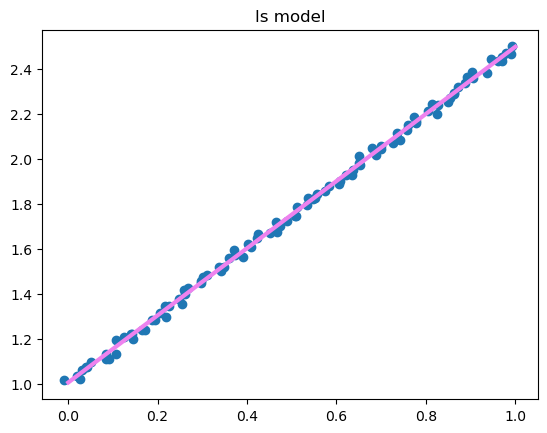

In [253]:
model_OLS = fit_line_ols(X.T)[0]
plt.figure()
plt.scatter(X[0,:], X[1,:])
plt.plot([0, 1], [model_OLS[1], model_OLS[0] + model_OLS[1]], 'violet', linewidth=3)
plt.title('ls model')
plt.show()

Least square fit via DLT (different model parametrization)

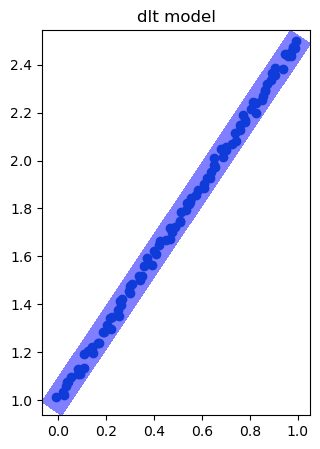

In [254]:
model_DLT = fit_line_dlt(X)[0]
plt.figure(figsize = (15,5))
plt.scatter(X[0,:], X[1,:])
display_band(X, model_DLT, BAND_WIDTH , BAND_COLOR)
plt.title('dlt model')
plt.show()

Add a single outlier to the data, obtaining a new dataset $X_{out}$

In [255]:
outlier = np.array([[0.0, 2.3]])
X_out = np.concatenate((X, outlier.T), axis=1)

Least square fit to noisy data with a single outlier

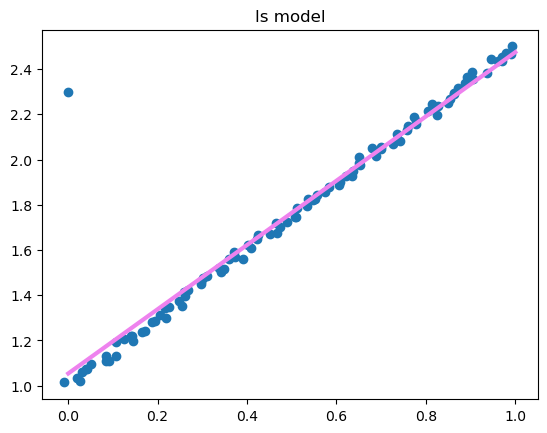

In [256]:
model_OLS = fit_line_ols(X_out.T)[0]
plt.figure()
plt.scatter(X_out[0,:], X_out[1,:])
plt.plot([0, 1], [model_OLS[1], model_OLS[0] + model_OLS[1]], 'violet', linewidth=3)
plt.title('ls model')
plt.show()

Least square fit via DLT to noisy data with a single outlier

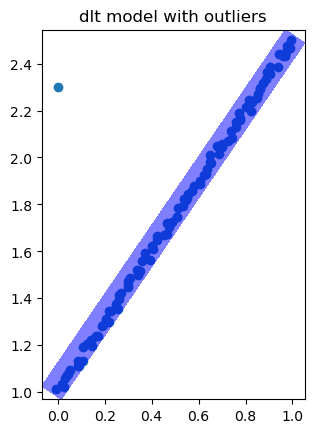

In [257]:
model_DLT = fit_line_dlt(X_out)[0]
plt.figure()
plt.scatter(X_out[0,:], X_out[1,:])
display_band(X_out, model_DLT, BAND_WIDTH , BAND_COLOR)
plt.title('dlt model with outliers')
plt.show()

Add many outliers to the noisy data

In [258]:
def add_noise(point, lb, ub):
    x_point = point[0]
    y_point = point[1]
    x_noise = np.random.uniform(lb,ub)
    y_noise = np.random.uniform(lb,ub)
    point[0] = x_point + x_noise
    point[1] = y_point + y_noise
    m = (point[1] - y_point) / (point[0] - x_point)
    if (m >= 1.3 and m <= 1.7) or (point[0] >= 1 and point[0] <= 0 or point[1] >= 2.5 and point[1] <= 1):
        return add_noise(point, lb, ub)
    return point


In [259]:
#n_out has to be less than the number of points in the dataset
n_out = 50
random_sample = X_out[:,np.random.choice(X_out.shape[1], n_out, replace=False)]
for i in range(n_out):
    #Get point from random sample
    point = random_sample[:,i]
    #Add noise to the point between -0.7 and 0.7
    point = add_noise(point, -0.7, 0.7)
    
    #Pin the compoents of the point to the range of the dataset
    point[0] = np.clip(point[0],0,1)
    point[1] = np.clip(point[1],1,2.5)
    X_out = np.concatenate((X_out, point[:,np.newaxis]), axis=1)


Least square fit

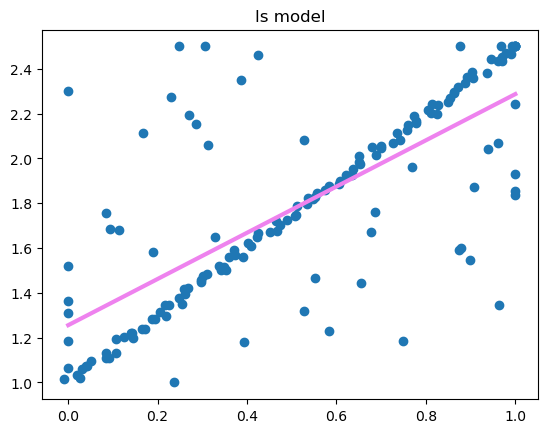

In [260]:
model_OLS = fit_line_ols(X_out.T)[0]

plt.figure()
plt.scatter(X_out[0,:], X_out[1,:])
plt.plot([0, 1], [model_OLS[1], model_OLS[0] + model_OLS[1]], 'violet', linewidth=3)
plt.title('ls model')
plt.show()

Least square via DLT

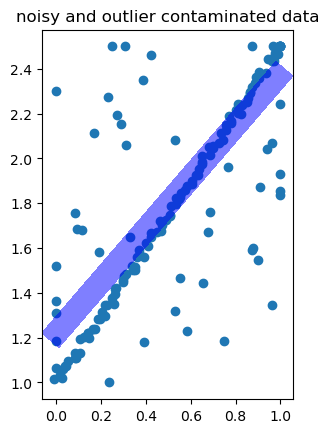

In [261]:
model_DLT = fit_line_dlt(X_out)[0]

plt.figure()
plt.scatter(X_out[0,:], X_out[1,:])
display_band(X_out, model_DLT, BAND_WIDTH , BAND_COLOR)
plt.title('noisy and outlier contaminated data')
plt.show()

Robust Fitting methods
----------------------
Use Ransac, M-Sac and L-Meds to perform fitting on data with many outliers

Ransac:


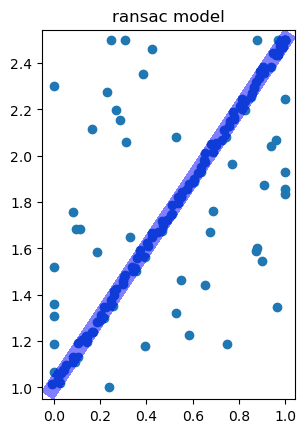

In [262]:
epsi = 3 * sigma # define inlier threshold

# invoke simpleRANSAC
bestmodel, bestinliers = simpleRANSAC(X_out, epsi, cardmss)

# refine model estimates
refinedModel = fit_line_dlt(X_out[:, bestinliers])[0]

plt.figure()
plt.scatter(X_out[0,:], X_out[1,:])
display_band(X_out, refinedModel, epsi, BAND_COLOR)
plt.title('ransac model')
plt.show()

M-Sac:

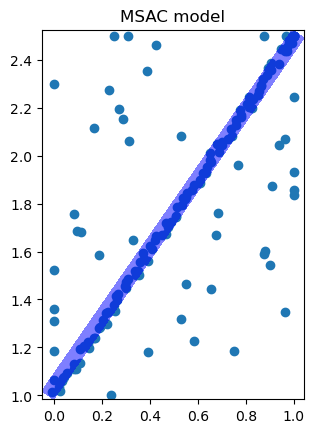

In [263]:
bestmodel, bestinliers = simpleMSAC(X_out, epsi, cardmss)

# refine model estimates
refinedModel = fit_line_dlt(X_out[:, bestinliers])[0]

plt.figure()
plt.scatter(X_out[0,:], X_out[1,:])
display_band(X_out, refinedModel, epsi, BAND_COLOR)
plt.title('MSAC model')
plt.show()

L-Meds:

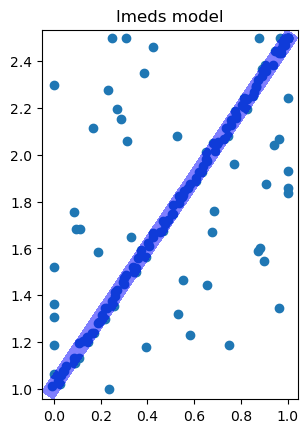

In [264]:
# invoke simpleLMEDS
bestmodel, bestinliers = simpleLMEDS(X_out, cardmss)

# refine model estimates
refinedModel = fit_line_dlt(X_out[:, bestinliers])[0]

plt.figure()
plt.scatter(X_out[0,:], X_out[1,:])
display_band(X_out, refinedModel, epsi, BAND_COLOR)
plt.title('lmeds model')
plt.show()
